<a href="https://colab.research.google.com/github/a-pujahari/EVA7/blob/main/Session12/EVA7_Session12_SpatialTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EVA7 - Spatial Transformer on CIFAR10 Dataset
## Submission by Abhinav Pujahari (abhinavpujahari@gmail.com)



## Import Dependencies

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!pip install torchsummary

## Calculate Dataset Statistics

In [3]:
def return_dataset_statistics():
    
    train_transform = transforms.Compose([transforms.ToTensor()])
    train_set = datasets.CIFAR10(root='./data', train = True, download = True, transform = train_transform)
    
    mean = train_set.data.mean(axis=(0,1,2))/255
    std = train_set.data.std(axis=(0,1,2))/255

    return mean, std

mean, std = return_dataset_statistics()
print(mean)
print(std)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


## Define Dataloaders

In [4]:
from torch.cuda import set_device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(mean = mean, std = std)
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = mean, std = std)
    ])), batch_size=64, shuffle=True, num_workers=4)

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Define Model

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(32*5*5, 1024)
        self.fc2 = nn.Linear(1024, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(True),
            nn.Linear(256, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, xs.size(1) * xs.size(2) * xs.size(3))
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 32*5*5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)




## Model Summary

In [6]:
from torchsummary import summary

print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 26, 26]           9,472
         MaxPool2d-2           [-1, 64, 13, 13]               0
              ReLU-3           [-1, 64, 13, 13]               0
            Conv2d-4            [-1, 128, 9, 9]         204,928
         MaxPool2d-5            [-1, 128, 4, 4]               0
              ReLU-6            [-1, 128, 4, 4]               0
            Linear-7                  [-1, 256]         524,544
              ReLU-8                  [-1, 256]               0
            Linear-9                    [-1, 6]           1,542
           Conv2d-10           [-1, 16, 28, 28]           1,216
           Conv2d-11           [-1, 32, 10, 10]          12,832
        Dropout2d-12           [-1, 32, 10, 10]               0
           Linear-13                 [-1, 1024]         820,224
           Linear-14              

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


## Train & Test Functions

In [7]:
optimizer = optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


# A simple test procedure to measure STN the performances on MNIST.
def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

## Train Model

In [8]:
for epoch in range(1, 51):
    train(epoch)
    test()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify ali

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.301728
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.981925


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 1.8304, Accuracy: 3431/10000 (34%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.004818
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.682925

Test set: Average loss: 1.6111, Accuracy: 4202/10000 (42%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.792376
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.718828

Test set: Average loss: 1.5415, Accuracy: 4474/10000 (45%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.819720
Train Epoch: 4 [32000/50000 (64%)]	Loss: 1.573076

Test set: Average loss: 1.4425, Accuracy: 4832/10000 (48%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.329195
Train Epoch: 5 [32000/50000 (64%)]	Loss: 1.455489

Test set: Average loss: 1.4184, Accuracy: 4880/10000 (49%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 1.430230
Train Epoch: 6 [32000/50000 (64%)]	Loss: 1.434268

Test set: Average loss: 1.3516, Accuracy: 5149/10000 (51%)

Train Epoch: 7 [0/50000 (0%)]	Loss: 1.355284
Train Epoch: 7 [32000/50000 (64%)]	Loss: 1.534765

Test set: Average loss: 1.3464, Accuracy: 5206/10000 (52%)

Tra

## Visualize Results

In [9]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify ali

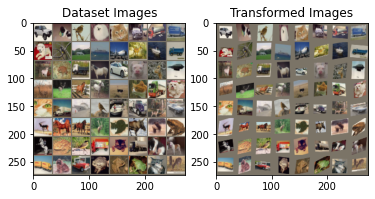

In [10]:
visualize_stn()

plt.ioff()
plt.show()